In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import numpy as np

import datetime as dt

In [2]:
from scipy.optimize import minimize

In [3]:
from scipy.optimize import basinhopping
from itertools import product

In [4]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
# px를 쉽고 빠르게 붙여주는 모듈 cufflinksget_rsi
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')

import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

import math

In [5]:
%run ../library/QUANT_FUNCTIONS.ipynb
Q = QUANT()
D = DATA()

In [6]:
## 날짜 도출
def getTEvents(gRaw, ph, nh):
    '''
    gRaw: 원계열
    ph: 양의 임계점
    nh: 음의 임계점
    ** 누적 변화량이 임계점을 초과한 지점을 표시함
    '''
    pEvents, nEvents, sPos, sNeg = [], [], 0, 0
    diff = np.log(gRaw).diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])

        if sPos > ph:
            sPos = 0
            pEvents.append(i)

        elif sNeg < -nh:
            sNeg = 0
            nEvents.append(i)
            
    long = pd.DatetimeIndex(nEvents)
    short = pd.DatetimeIndex(pEvents)
    
    ## 중복되는 의사결정을 제거함
    short_ = []
    for i in range(len(long)):
        if len(short[short > long[i]]) > 0:
            short_.append(short[short > long[i]][0])

    long_ = []
    for i in range(len(short_)):
        if i == 0:
            long_.append(long[(long < short_[i])][0])
        else:
            if len(long[(long > short_[i-1])&(long < short_[i])]) > 0:
                long_.append(long[(long > short_[i-1])&(long < short_[i])][0])
    
    return sorted(pd.DatetimeIndex(set(long_))), sorted(pd.DatetimeIndex(set(short_)))


## score 도출
def get_score(df, col, hs):
    
    ph = hs[0]
    nh = hs[1]
    long, short  = getTEvents(df[col], ph/100, nh/100)
    long_, short_ = getTEvents_all(df[col], ph/100, nh/100)
    if len(long_[long_ > short[-1]]) > 0:
        long.append(long_[long_ > short[-1]][0])

    taget_df = df[[col]].copy()
    ## 롱숏 신호부여
    taget_df['long'] = 0
    taget_df['long'][long] = 1
    taget_df['short'] = 0
    taget_df['short'][short] = 1
    taget_df['signal'] = (taget_df['long'] - taget_df['short'].shift(1)).fillna(0)
    taget_df['position'] = taget_df['signal'].cumsum()
    ## 포지션에 따른 가치(환산전)
    taget_df['strategy'] = taget_df['position'] * taget_df[col]
    taget_df['strategy'][taget_df['strategy'] == 0] = np.nan
    ## 매수시점 가격
    taget_df['last_price'] = np.nan
    taget_df['last_price'][taget_df['long'] == 1] = taget_df[col]
    taget_df['last_price'] = taget_df['last_price'].fillna(method='pad')
    taget_df['last_price'] = taget_df['last_price'].fillna(1)
    ## 포지션에 따른 가치(매수시점 가격 환원)
    taget_df['strategy'] = (taget_df['strategy']/taget_df['last_price'])

    ## 매수시점 자산가치
    taget_df['last_value'] = np.nan
    temp = [1]
    for i in list(taget_df['strategy'][taget_df['short'] == 1].cumprod()):
        temp.append(i)
    taget_df['last_value'][taget_df['long'] == 1] = temp
    taget_df['last_value'] = taget_df['last_value'].fillna(method='pad')
    taget_df['last_value'] = taget_df['last_value'].fillna(method='bfill')

    ## 포지션에 따른 가치(매수시점 자산가지 환원)
    taget_df['strategy'] = taget_df['strategy'] * taget_df['last_value']
    taget_df['strategy'] = taget_df['strategy'].fillna(method='pad')
    taget_df['strategy'] = taget_df['strategy'].fillna(method='bfill')

    score = taget_df['strategy'][-1]
    
    MR = taget_df['strategy'].pct_change().mean()*250
    MV = taget_df['strategy'].pct_change().std()*250
    
    return score, taget_df, MR, MV

def getTEvents_all(gRaw, ph, nh):
    '''
    gRaw: 원계열
    ph: 양의 임계점
    nh: 음의 임계점
    ** 누적 변화량이 임계점을 초과한 지점을 표시함
    '''
    pEvents, nEvents, sPos, sNeg = [], [], 0, 0
    diff = np.log(gRaw).diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])

        if sPos > ph:
            sPos = 0
            pEvents.append(i)

        elif sNeg < -nh:
            sNeg = 0
            nEvents.append(i)
            
    long = pd.DatetimeIndex(nEvents)
    short = pd.DatetimeIndex(pEvents)
    
    return long, short

## Data

In [7]:
## 다우 30
'''df = D.get_merged_df('AAPL', 'MSFT', 'V', 'JPM', 'JNJ', 'WMT', 'UNH', 'PG',
                     'HD', 'DIS', 'NKE', 'CSCO', 'CRM', 'KO', 'VZ', 'INTC',
                     'MRK', 'CVX', 'MCD', 'HON', 'GS', 'AXP', 'BA', 'AMGN',
                     'IBM', 'CAT', 'MMM', 'DOW', 'WBA', 'TRV')'''

"df = D.get_merged_df('AAPL', 'MSFT', 'V', 'JPM', 'JNJ', 'WMT', 'UNH', 'PG',\n                     'HD', 'DIS', 'NKE', 'CSCO', 'CRM', 'KO', 'VZ', 'INTC',\n                     'MRK', 'CVX', 'MCD', 'HON', 'GS', 'AXP', 'BA', 'AMGN',\n                     'IBM', 'CAT', 'MMM', 'DOW', 'WBA', 'TRV')"

In [8]:
## etfs
## df = D.get_merged_df('TQQQ', 'UPRO', 'EURL', 'EDC')

In [9]:
df = D.get_merged_df('QQQ', 'QLD', 'TQQQ', '^KS11')

## Back test

In [10]:
## dataset = df['2000':].dropna(axis=1)
dataset = df.dropna()
dataset = dataset/np.array(dataset)[0]

In [11]:
res_ls = []
for col in dataset.columns:
    print(f"{col} 진행중")

    ph_ls = range(50, 201, 5)
    nh_ls = range(5, 51, 5)
    h_ls = list(product(*[ph_ls, nh_ls]))

    for hs in h_ls:
        ## print(hs)
        try:
            score, _, MR, MV = get_score(dataset, col, hs)
            res_ls.append([col, hs[0], hs[1], score, MR, MV])
        except Exception as e:
            None
            ## print('값없음')

QQQ 진행중
QLD 진행중
TQQQ 진행중
^KS11 진행중


In [12]:
result = pd.DataFrame(res_ls, columns=['ticker', 'short_point', 'long_point', 'value', 'return', 'volatility'])
result['sharp'] = result['return']/result['volatility']

In [13]:
col = 'TQQQ'
result[result['ticker'] == col].sort_values('sharp', ascending=False)

,ticker,short_point,long_point,value,return,volatility,sharp
600,TQQQ,120,35,138.856345,0.570130,8.818798,0.064649
763,TQQQ,200,50,121.034117,0.551223,8.600172,0.064094
520,TQQQ,80,35,102.199778,0.522482,8.189934,0.063796
610,TQQQ,125,35,128.178612,0.569053,8.976245,0.063395
753,TQQQ,195,50,103.059699,0.531481,8.417168,0.063143
...,...,...,...,...,...,...,...
491,TQQQ,65,40,5.677668,0.248616,7.141065,0.034815
483,TQQQ,60,50,4.328479,0.197820,6.084906,0.032510
492,TQQQ,65,45,4.444560,0.213338,6.607503,0.032287
481,TQQQ,60,40,4.027244,0.215737,6.993168,0.030850


In [14]:
hs = [120, 35]
df = dataset.copy()

In [15]:
_, res, _, _ = get_score(df, col, hs)

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [17]:
res['strategy'].pct_change().mean()

0.0022805195115988405

In [18]:
res[col].pct_change().mean()

0.0021844061625642913

In [19]:
((res[col][-1]/res[col][0])-1)**(1/len(res))

1.001415140335302

In [20]:
(((res[col][-1]/res[col][0])-1)**(1/len(res)))**250

1.4240928178926835

In [21]:
(((res['strategy'][-1]/res['strategy'][0])-1)**(1/len(res)))**250

1.5086316058562002

In [22]:
res[res['long'] == 1].index

DatetimeIndex(['2010-05-20', '2012-05-18', '2015-08-24', '2018-04-02',
               '2020-02-27', '2020-09-08', '2022-01-20'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [24]:
res

,TQQQ,long,short,signal,position,strategy,last_price,last_value
Date,,,,,,,,
2010-02-11,1.000000,0,0,0.0,0.0,1.000000,1.000000,1.000000
2010-02-12,1.004094,0,0,0.0,0.0,1.000000,1.000000,1.000000
2010-02-16,1.042987,0,0,0.0,0.0,1.000000,1.000000,1.000000
2010-02-17,1.060686,0,0,0.0,0.0,1.000000,1.000000,1.000000
2010-02-18,1.080795,0,0,0.0,0.0,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
2022-08-22,75.485929,0,0,0.0,1.0,149.555263,143.416316,284.141231
2022-08-23,75.230986,0,0,0.0,1.0,149.050161,143.416316,284.141231
2022-08-24,75.810399,0,0,0.0,1.0,150.198113,143.416316,284.141231


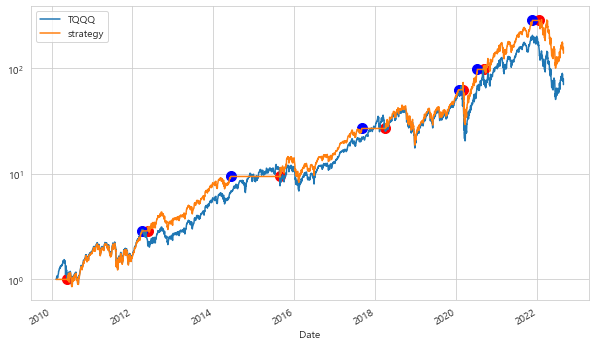

In [23]:
res[[col, 'strategy']].plot()
plt.scatter(res[res['long'] == 1].index,res[res['long'] == 1]['strategy'], color = 'r',s=100)
plt.scatter(res[res['short'] == 1].index,res[res['short'] == 1]['strategy'], color = 'b',s=100)
plt.yscale("log")